# LearnX Sales Forecasting

Sales data for more than 2 years from 600 courses of LearnX's top domains is available along with information on

Competition in the market for each course
Course Type (Course/Program/Degree)
Holiday Information for each day
User Traffic on Course Page for each day

Your task is to predict the course sales for each course in the test set for the next 60 days

## Data Dictionary
Train (Historical Sales Data)
Variable	Definition
ID - Unique Identifier for a row
Day_No	- Day Number
Course_ID	- Unique ID for a course
Course_Domain	- Course Domain (Development, Finance etc.)
Course_Type - 	Course/Program/Degree
Short_Promotion	- Whether Short Term Promotion is Live
Public_Holiday	- Regional/Public Holiday
Long_Promotion	- Whether Long Term Promotion is Live for the course
User_Traffic	- Number of customers landing on the course page
Competition_Metric	- A metric defining the strength of competition 
Sales - (Target) Total Course Sales

In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

C:\Users\Asmita\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample_sunmission.csv")

In [3]:
print(train.shape)
print(test.shape)

(512087, 11)
(36000, 9)


In [4]:
train.nunique()

ID                    512087
Day_No                   882
Course_ID                600
Course_Domain              4
Course_Type                3
Short_Promotion            2
Public_Holiday             2
Long_Promotion             2
User_Traffic            3475
Competition_Metric       196
Sales                    544
dtype: int64

In [5]:
df1 = pd.DataFrame({"Day_No": train["Day_No"].iloc[0:882],
                   "Date": pd.date_range(start = "2017-10-29", periods = 882, freq = "D")})
df1["Day_No"].astype(int)
train_df = pd.merge(train, df1, on = "Day_No", how = "left")

In [6]:
df2 = pd.DataFrame({"Day_No": test["Day_No"].iloc[0:60],
                   "Date": pd.date_range(start = "2020-03-29", periods = 60, freq = "D")})
df2["Day_No"].astype(int)
test_df = pd.merge(test, df2, on = "Day_No", how = "left")

In [7]:
train_df.drop('ID', axis = 1, inplace = True)
test_df.drop('ID', axis = 1, inplace = True)

In [8]:
train_df["Competition_Metric"].fillna(train_df['Competition_Metric'].mean(), inplace = True)
test_df["Competition_Metric"].fillna(test_df['Competition_Metric'].mean(), inplace = True)

In [9]:
print(train_df['Course_Domain'].value_counts())
print(train_df['Course_Type'].value_counts())

Development             264295
Software Marketing      166172
Finance & Accounting     77210
Business                  4410
Name: Course_Domain, dtype: int64
Course     262747
Program    247576
Degree       1764
Name: Course_Type, dtype: int64


### Feature Engineering

In [10]:
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df['week'] = train_df['Date'].dt.weekofyear
train_df['month'] = train_df['Date'].dt.month
train_df['week_day'] = train_df['Date'].dt.dayofweek
train_df['day_of_year'] = train_df['Date'].dt.dayofyear
train_df['day'] = train_df['Date'].dt.day
train_df['month_end'] = train_df['Date'].dt.is_month_end
train_df['month_start'] = train_df['Date'].dt.is_month_start


test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df['week'] = test_df['Date'].dt.weekofyear
test_df['month'] = test_df['Date'].dt.month
test_df['week_day'] = test_df['Date'].dt.dayofweek
test_df['day_of_year'] = test_df['Date'].dt.dayofyear
test_df['day'] = test_df['Date'].dt.day
test_df['month_end'] = test_df['Date'].dt.is_month_end
test_df['month_start'] = test_df['Date'].dt.is_month_start

In [11]:
course_domain_dict = {'Development':0, 'Software Marketing':1, 'Finance & Accounting':2, 'Business':3}
course_type_dict = {'Course':0, 'Program':1, 'Degree':2}
train_df['Course_Domain'] = train_df['Course_Domain'].apply(lambda x : course_domain_dict[x])
test_df['Course_Domain'] = test_df['Course_Domain'].apply(lambda x : course_domain_dict[x])

train_df['Course_Type'] = train_df['Course_Type'].apply(lambda x : course_type_dict[x])
test_df['Course_Type'] = test_df['Course_Type'].apply(lambda x : course_type_dict[x])

In [12]:
train_df['month_end'] = train_df['month_end'].astype(str)
train_df['month_start'] = train_df['month_start'].astype(str)
month_end_dict = {'False' : 0, 'True' : 1}
month_start_dict = {'False' : 0, 'True' : 1}
train_df['month_start'] = train_df['month_start'].apply(lambda x : month_start_dict[x])
train_df['month_end'] = train_df['month_end'].apply(lambda x : month_end_dict[x])


test_df['month_end'] = test_df['month_end'].astype(str)
test_df['month_start'] = test_df['month_start'].astype(str)
test_df['month_start'] = test_df['month_start'].apply(lambda x : month_start_dict[x])
test_df['month_end'] = test_df['month_end'].apply(lambda x : month_end_dict[x])

In [13]:
train_df.drop('Day_No', axis = 1, inplace = True)
test_df.drop('Day_No', axis = 1, inplace = True)

In [14]:
User_data = train_df.groupby("Course_ID").agg({"User_Traffic": ["sum","mean"], "Sales": ["sum","mean"]})
User_data.columns = ['total_traffic_courseid','mean_traffic_courseid','total_sales_courseid',
                    'mean_sales_courseid']
User_data = User_data.reset_index(drop = False)
train_df = train_df.merge(User_data, on = "Course_ID", how = "left")
test_df = test_df.merge(User_data, on = "Course_ID", how = "left")

In [15]:
train_df['traffic_rank_id'] = train_df.groupby("Course_ID")['total_traffic_courseid'].rank()
train_df['sales_rank_id'] = train_df.groupby("Course_ID")['total_sales_courseid'].rank()
test_df['traffic_rank_id'] = test_df.groupby("Course_ID")['total_traffic_courseid'].rank()
test_df['sales_rank_id'] = test_df.groupby("Course_ID")['total_sales_courseid'].rank()

In [16]:
train_df['buy_percent'] =(train_df['total_sales_courseid']*100)/ train_df['total_traffic_courseid']    
test_df['buy_percent'] =(test_df['total_sales_courseid']*100)/ test_df['total_traffic_courseid']    

In [17]:
User_data = train_df.groupby(["Course_ID", "Course_Domain"]).agg({"User_Traffic": ["sum","mean"],
                    "Sales": ["sum","mean"]})
User_data.columns = ['tot_traffic_id_domain','mean_traffic_id_domain','tot_sales_id_domain',
                    'mean_sales_id_domain']
User_data = User_data.reset_index(drop = False)
train_df = train_df.merge(User_data, on = ["Course_ID","Course_Domain"], how = "left")
test_df = test_df.merge(User_data, on = ["Course_ID","Course_Domain"], how = "left")

In [18]:
train_df['buy_percent_id_domain'] =(train_df['tot_sales_id_domain']*100)/train_df['tot_traffic_id_domain'] 
test_df['buy_percent_id_domain'] =(test_df['tot_sales_id_domain']*100)/test_df['tot_traffic_id_domain']     

In [19]:
User_data = train_df.groupby(["Course_ID", "Course_Type"]).agg({"User_Traffic": ["sum","mean"],
                    "Sales": ["sum","mean"]})
User_data.columns = ['tot_traffic_id_type','mean_traffic_id_type','tot_sales_id_type',
                    'mean_sales_id_domain']
User_data = User_data.reset_index(drop = False)
train_df = train_df.merge(User_data, on = ["Course_ID","Course_Type"], how = "left")
test_df = test_df.merge(User_data, on = ["Course_ID","Course_Type"], how = "left")

In [20]:
train_df['buy_percent_id_type'] =(train_df['tot_sales_id_type']*100)/train_df['tot_traffic_id_type']   
test_df['buy_percent_id_type'] =(test_df['tot_sales_id_type']*100)/test_df['tot_traffic_id_type']    

In [21]:
User_data = train_df.groupby(["Course_ID", "Course_Domain","Course_Type"]).agg({"User_Traffic":
                ["sum","mean"],"Sales": ["sum","mean"]})
User_data.columns = ['tot_traffic_id_do_ty','mean_traffic_id_do_ty','tot_sales_id_do_ty',
                    'mean_sales_id_do_ty']
User_data = User_data.reset_index(drop = False)
train_df = train_df.merge(User_data, on = ["Course_ID","Course_Domain","Course_Type"], how = "left")
test_df = test_df.merge(User_data, on = ["Course_ID","Course_Domain","Course_Type"], how = "left")

In [22]:
User_data = train_df.groupby(["Course_ID", "week_day"]).agg({"User_Traffic":"sum","Sales": "sum"})
User_data.columns = ['tot_traffic_id_weekday', 'tot_sales_id_weekday']
User_data = User_data.reset_index(drop = False)
train_df = train_df.merge(User_data, on = ["Course_ID","week_day"], how = "left")
test_df = test_df.merge(User_data, on = ["Course_ID","week_day"], how = "left")

In [23]:
User_data = train_df.groupby(["Course_ID", "week"]).agg({"User_Traffic":"sum","Sales": "sum"})
User_data.columns = ['tot_traffic_id_week', 'tot_sales_id_week']
User_data = User_data.reset_index(drop = False)
train_df = train_df.merge(User_data, on = ["Course_ID","week"], how = "left")
test_df = test_df.merge(User_data, on = ["Course_ID","week"], how = "left")

In [24]:
User_data = train_df.groupby("Course_ID").agg({"Competition_Metric": "mean"})
User_data.columns = ['mean_metric_id']
User_data = User_data.reset_index(drop = False)
train_df = train_df.merge(User_data, on = "Course_ID", how = "left")
test_df = test_df.merge(User_data, on = "Course_ID", how = "left")

In [25]:
train_df['metric_rank_id'] = train_df.groupby("Course_ID")['mean_metric_id'].rank()
test_df['metric_rank_id'] = test_df.groupby("Course_ID")['mean_metric_id'].rank()

In [26]:
User_data = train_df.groupby(["Course_ID","Long_Promotion"]).agg({"Competition_Metric": "mean"})
User_data.columns = ['mean_metric_id_longpro']
User_data = User_data.reset_index(drop = False)
train_df = train_df.merge(User_data, on = ["Course_ID","Long_Promotion"], how = "left")
test_df = test_df.merge(User_data, on = ["Course_ID","Long_Promotion"], how = "left")

In [27]:
User_data = train_df.groupby(["Course_ID","Short_Promotion"]).agg({"Competition_Metric": "mean"})
User_data.columns = ['mean_metric_id_Shortpro']
User_data = User_data.reset_index(drop = False)
train_df = train_df.merge(User_data, on = ["Course_ID","Short_Promotion"], how = "left")
test_df = test_df.merge(User_data, on = ["Course_ID","Short_Promotion"], how = "left")

In [28]:
User_data = train_df.groupby(["Course_ID","week_day"]).agg({"Competition_Metric": "mean"})
User_data.columns = ['mean_metric_id_weekday']
User_data = User_data.reset_index(drop = False)
train_df = train_df.merge(User_data, on = ["Course_ID","week_day"], how = "left")
test_df = test_df.merge(User_data, on = ["Course_ID","week_day"], how = "left")

In [29]:
train_df['sales_shift1'] = train_df.groupby("Course_ID")["Sales"].shift(1).fillna(0)
train_df['sales_shift3'] = train_df.groupby("Course_ID")["Sales"].shift(3).fillna(0)
train_df['sales_shift5'] = train_df.groupby("Course_ID")["Sales"].shift(5).fillna(0)
train_df['sales_shift7'] = train_df.groupby("Course_ID")["Sales"].shift(7).fillna(0)

In [30]:
train_df['change_sales_1day'] = (train_df['sales_shift1'] - train_df['Sales'])*100/train_df['Sales'] 
train_df['change_sales_3day'] = (train_df['sales_shift3'] - train_df['Sales'])*100/train_df['Sales'] 
train_df['change_sales_5day'] = (train_df['sales_shift5'] - train_df['Sales'])*100/train_df['Sales'] 
train_df['change_sales_7day'] = (train_df['sales_shift7'] - train_df['Sales'])*100/train_df['Sales'] 

In [31]:
User_data = train_df.groupby("Course_ID").agg({"change_sales_1day": "mean", "change_sales_3day": "mean",
                        "change_sales_5day":"mean", "change_sales_7day": "mean"})
User_data.columns = ['mean_change_sales1day', 'mean_change_sales3day','mean_change_sales5day',
                    'mean_change_sales7day']
User_data = User_data.reset_index(drop = False)
train_df = train_df.merge(User_data, on = "Course_ID", how = "left")
test_df = test_df.merge(User_data, on = "Course_ID", how = "left")

In [32]:
train_df['traffic_shift1'] = train_df.groupby("Course_ID")["User_Traffic"].shift(1).fillna(0)
train_df['traffic_shift3'] = train_df.groupby("Course_ID")["User_Traffic"].shift(3).fillna(0)
train_df['traffic_shift5'] = train_df.groupby("Course_ID")["User_Traffic"].shift(5).fillna(0)
train_df['traffic_shift7'] = train_df.groupby("Course_ID")["User_Traffic"].shift(7).fillna(0)

In [33]:
train_df['change_traffic_1day'] = (train_df['traffic_shift1'] - train_df['User_Traffic'])*100/train_df['User_Traffic'] 
train_df['change_traffic_3day'] = (train_df['traffic_shift3'] - train_df['User_Traffic'])*100/train_df['User_Traffic'] 
train_df['change_traffic_5day'] = (train_df['traffic_shift5'] - train_df['User_Traffic'])*100/train_df['User_Traffic'] 
train_df['change_traffic_7day'] = (train_df['traffic_shift7'] - train_df['User_Traffic'])*100/train_df['User_Traffic'] 

In [34]:
User_data = train_df.groupby("Course_ID").agg({"change_traffic_1day": "mean", "change_traffic_3day": "mean",
                        "change_traffic_5day":"mean", "change_traffic_7day": "mean"})
User_data.columns = ['mean_change_traffic1day', 'mean_change_traffic3day','mean_change_traffic5day',
                    'mean_change_traffic7day']
User_data = User_data.reset_index(drop = False)
train_df = train_df.merge(User_data, on = "Course_ID", how = "left")
test_df = test_df.merge(User_data, on = "Course_ID", how = "left")

In [35]:
train_df.drop(['User_Traffic','Date'], axis = 1, inplace = True)
test_df.drop('Date', axis = 1, inplace = True)

In [36]:
train_df.drop(['sales_shift1', 'sales_shift3','sales_shift5', 'sales_shift7', 'change_sales_1day',
       'change_sales_3day', 'change_sales_5day', 'change_sales_7day','traffic_shift1','traffic_shift3',
        'traffic_shift5', 'traffic_shift7', 'change_traffic_1day', 'change_traffic_3day',
        'change_traffic_5day', 'change_traffic_7day'], axis = 1, inplace = True)

In [37]:
train_df = train_df.replace(np.inf, 0)
train_df = train_df.fillna(0)
test_df = test_df.replace(np.inf, 0)
test_df = test_df.fillna(0)

In [38]:
from pandas import set_option
correlation = train_df.corr()
set_option('display.width', 100)
set_option('precision', 3)
print (correlation)

                         Course_ID  Course_Domain  Course_Type  Short_Promotion  Public_Holiday  \
Course_ID                1.000e+00      5.524e-02    5.299e-02       -2.695e-05       1.242e-03   
Course_Domain            5.524e-02      1.000e+00    1.291e-01        1.158e-05      -1.442e-04   
Course_Type              5.299e-02      1.291e-01    1.000e+00        3.272e-04      -2.394e-03   
Short_Promotion         -2.695e-05      1.158e-05    3.272e-04        1.000e+00      -1.877e-02   
Public_Holiday           1.242e-03     -1.442e-04   -2.394e-03       -1.877e-02       1.000e+00   
Long_Promotion          -3.961e-02      4.563e-02    2.006e-02       -1.149e-03       8.319e-03   
Competition_Metric      -7.381e-03     -4.397e-02    1.295e-01        1.821e-04      -4.906e-04   
Sales                    1.689e-02      5.091e-02    1.460e-01        3.678e-01      -1.351e-01   
week                    -1.832e-04      8.207e-05    2.049e-03       -2.629e-02      -5.045e-02   
month     

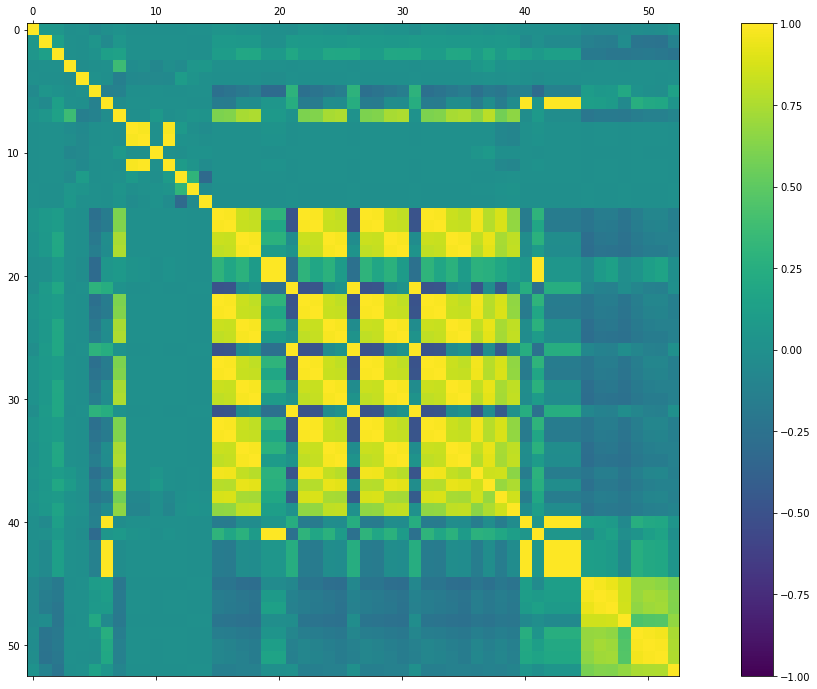

In [39]:
fig = plt.figure(figsize = (22, 12))
ax = fig.add_subplot(111)
cax = ax.matshow(correlation, vmin=-1, vmax=1)
fig.colorbar(cax)
plt.show()

In [38]:
test_df.columns

Index(['Course_ID', 'Course_Domain', 'Course_Type', 'Short_Promotion',
       'Public_Holiday', 'Long_Promotion', 'Competition_Metric', 'week',
       'month', 'week_day', 'day_of_year', 'day', 'month_end', 'month_start',
       'total_traffic_courseid', 'mean_traffic_courseid',
       'total_sales_courseid', 'mean_sales_courseid', 'traffic_rank_id',
       'sales_rank_id', 'buy_percent', 'tot_traffic_id_domain',
       'mean_traffic_id_domain', 'tot_sales_id_domain',
       'mean_sales_id_domain_x', 'buy_percent_id_domain',
       'tot_traffic_id_type', 'mean_traffic_id_type', 'tot_sales_id_type',
       'mean_sales_id_domain_y', 'buy_percent_id_type', 'tot_traffic_id_do_ty',
       'mean_traffic_id_do_ty', 'tot_sales_id_do_ty', 'mean_sales_id_do_ty',
       'tot_traffic_id_weekday', 'tot_sales_id_weekday', 'tot_traffic_id_week',
       'tot_sales_id_week', 'mean_metric_id', 'metric_rank_id',
       'mean_metric_id_longpro', 'mean_metric_id_Shortpro',
       'mean_metric_id_weekday', 

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
sfs = SFS(RandomForestRegressor(random_state =7, n_jobs = -1),
          k_features = 20,
          forward = True,
          floating = False,
          verbose = 2,
          scoring = 'neg_mean_squared_error',
          cv = 5,
          n_jobs = -1)
sfs = sfs.fit(X_train, Y_train)

In [39]:
train_df.shape

(512087, 53)

In [40]:
X = train_df.loc[:, train_df.columns != 'Sales']
Y = train_df.loc[:, ['Sales']]

In [41]:
# Splitting the train_data into the Training set and Test set
from sklearn.cross_validation import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

C:\Users\Asmita\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [161]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [42]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

C:\Users\Asmita\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [213]:
rf=  RandomForestRegressor(random_state=7)
rf.fit(X_train, Y_train)
pred = rf.predict(X_test)
print('Test Set')
print('MSE')
mean_squared_log_error(Y_test, pred)

Test Set
MSE


0.017781898540118926

In [132]:
rf.feature_importances_

array([0.00422353, 0.00131133, 0.00078877, 0.10245661, 0.01930762,
       0.00064388, 0.00236704, 0.02157429, 0.05651634, 0.00147922,
       0.00116921, 0.00106793, 0.00109369, 0.00256221, 0.02161661,
       0.00331559, 0.00333395, 0.00120465, 0.00097905, 0.00112747,
       0.00234541, 0.00121014, 0.00104361, 0.00109923, 0.00304677,
       0.00124298, 0.00104464, 0.00104595, 0.00299819, 0.01913156,
       0.00637533, 0.61954416, 0.02455632, 0.05234372, 0.00233976,
       0.00285844, 0.0054965 , 0.00413829])

In [133]:
for feature in zip(X.columns, rf.feature_importances_):
    print(feature)

('Course_ID', 0.00422353410345123)
('Course_Domain', 0.0013113335110404578)
('Course_Type', 0.0007887705485142551)
('Short_Promotion', 0.1024566124901263)
('Public_Holiday', 0.01930761630486538)
('Long_Promotion', 0.0006438753678010668)
('Competition_Metric', 0.0023670413459834566)
('week_day', 0.021574286067425952)
('day', 0.05651633518216102)
('month_end', 0.0014792183001108568)
('month_start', 0.001169214313975256)
('total_traffic_courseid', 0.0010679340969991058)
('mean_traffic_courseid', 0.0010936888293740397)
('total_sales_courseid', 0.002562212757774465)
('mean_sales_courseid', 0.021616609199072136)
('traffic_rank_id', 0.00331559439211723)
('sales_rank_id', 0.0033339490400848557)
('buy_percent', 0.0012046542577526514)
('tot_traffic_id_domain', 0.0009790517357177468)
('mean_traffic_id_domain', 0.0011274675214263188)
('tot_sales_id_domain', 0.002345409066379864)
('buy_percent_id_domain', 0.001210142315820895)
('tot_traffic_id_type', 0.0010436100783985608)
('mean_traffic_id_type', 

In [ ]:
plt.figure(figsize=(30,25))
df=pd.DataFrame({'feature': X.columns,'importances': rf.feature_importances_})
df.sort_values('importances',inplace=True)
df.plot(kind='barh',y='importances',x='feature',color='r',figsize = (25, 20), ylim = (0, 0.05))

In [50]:
from sklearn.linear_model import ElasticNet
ENreg = ElasticNet(alpha=1, l1_ratio=0.5, normalize=False)
ENreg.fit(X_train,Y_train)
pred_1 = ENreg.predict(X_test)
mean_squared_log_error(Y_test, pred_1)

0.08273499571089701

In [43]:
from sklearn.ensemble import ExtraTreesRegressor
et = ExtraTreesRegressor()
et.fit(X_train,Y_train)
pred_4 = et.predict(X_test)
mean_squared_error(Y_test, pred_4)

298.2200949051924

In [44]:
from xgboost import XGBRegressor
xgb = XGBRegressor()
xgb.fit(X_train,Y_train)
pred_7 = xgb.predict(X_test)
mean_squared_error(Y_test, pred_7)

415.1684891457364

In [49]:
from sklearn.linear_model import Ridge
rid = Ridge()
rid.fit(X_train,Y_train)
pred_7 = rid.predict(X_test)
mean_squared_error(Y_test, pred_7)

665.9289583802839

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
parameters = {'max_features':['auto','sqrt'],
             'bootstrap': [True, False],
             'max_depth': [10,15,20],
             'min_samples_split': [2,5,15,100],
             'min_samples_leaf': [2,5,10],
             'n_estimators': [200,400,600,800]}
rms = RandomizedSearchCV(estimator = RandomForestRegressor(random_state=7),
                         param_distributions = parameters,
                        scoring = 'neg_mean_squared_error', cv = 3, return_train_score=False)
rms.fit(X_train, Y_train)
pd.DataFrame(rms.cv_results_)[['max_features','bootstrap','max_depth','min_samples_split',
                               'min_samples_leaf','n_estimators','mean_test_score']]

In [103]:
pred_ENreg = ENreg.predict(test_df)
pred_et = et.predict(test_df)
pred_rid = rid.predict(test_df)

In [104]:
pred_rid = pred_rid.astype(int)
pred_et = pred_et.astype(int)
pred_rid = pred_ENreg.astype(int)

In [105]:
finalpred = 0.2*pred_ENreg + 0.3*pred_et + 0.5*pred_rid

In [106]:
submission['Sales'] = finalpred

In [107]:
submission['Sales']= submission['Sales'].astype(int)

In [108]:
submission['Sales'].describe()

count    36000.000000
mean       126.532056
std         45.582241
min         27.000000
25%         94.000000
50%        119.000000
75%        151.000000
max        402.000000
Name: Sales, dtype: float64

In [109]:
submission['Sales']

0        114
1        128
2         99
3         95
4         53
5         78
6         93
7         91
8         98
9         84
10        81
11        54
12        74
13       129
14       110
15       124
16       100
17        93
18        53
19        78
20        94
21        89
22        97
23        83
24        82
25        55
26        75
27       139
28       112
29       109
        ... 
35970    122
35971    131
35972    119
35973     96
35974    106
35975    101
35976     92
35977     93
35978    101
35979    117
35980     89
35981    139
35982    118
35983    116
35984    117
35985    126
35986    117
35987     93
35988    109
35989     98
35990     95
35991     97
35992    106
35993    124
35994     92
35995    144
35996    123
35997    124
35998    128
35999    138
Name: Sales, Length: 36000, dtype: int32

In [110]:
submission.to_csv('5RID_3ET_2ENREG.csv', index=False)

In [111]:
df = pd.read_csv("5RID_3ET_2ENREG.csv")

In [112]:
df.head(10)

,ID,Sales
0,883,114
1,884,128
2,885,99
3,886,95
4,887,53
5,888,78
6,889,93
7,890,91
8,891,98
9,892,84
